<a href="https://colab.research.google.com/github/clionelove123/temp_test/blob/main/Chap_10_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow
     

In [38]:

# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 50
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [39]:
# 텐서플로 데이터셋 로드 
ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

In [40]:
# 이미지 전처리 함수 
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크 
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask
     

In [41]:

# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [42]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

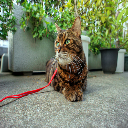

In [43]:
# 샘플 이미지 출력 
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)  

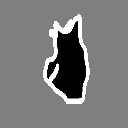

In [44]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)    

In [45]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

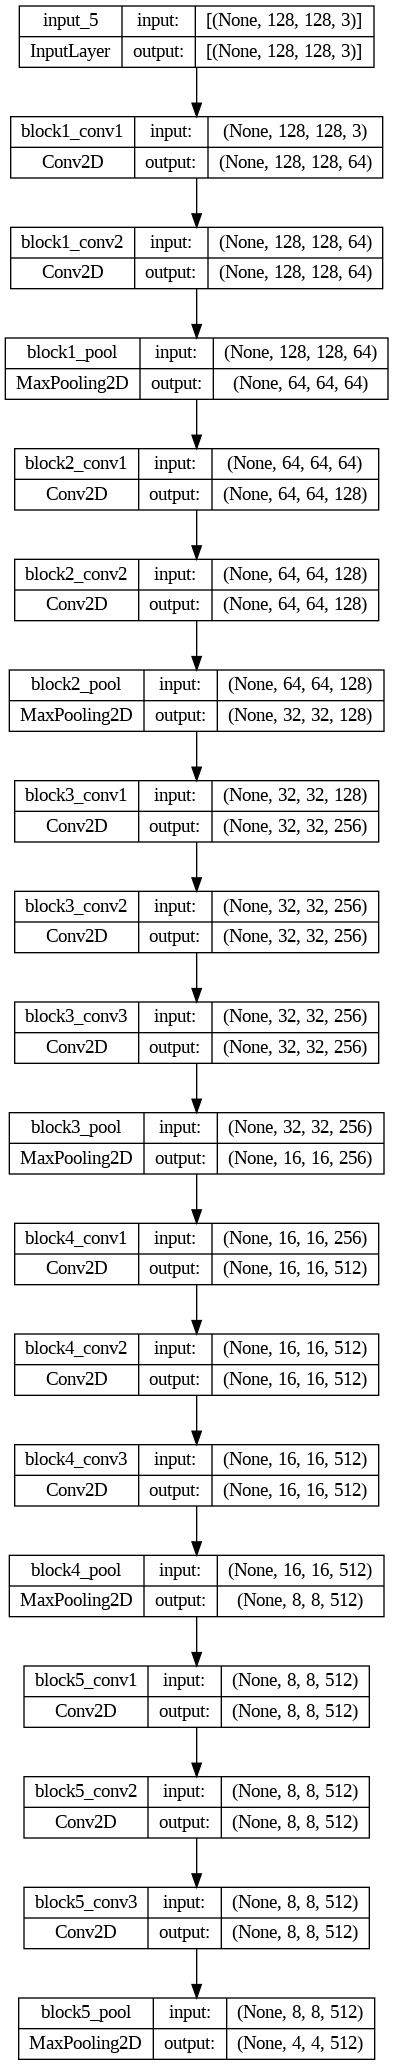

In [46]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

In [47]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

In [48]:
# 파라미터 고정
f_model.trainable = False

In [49]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

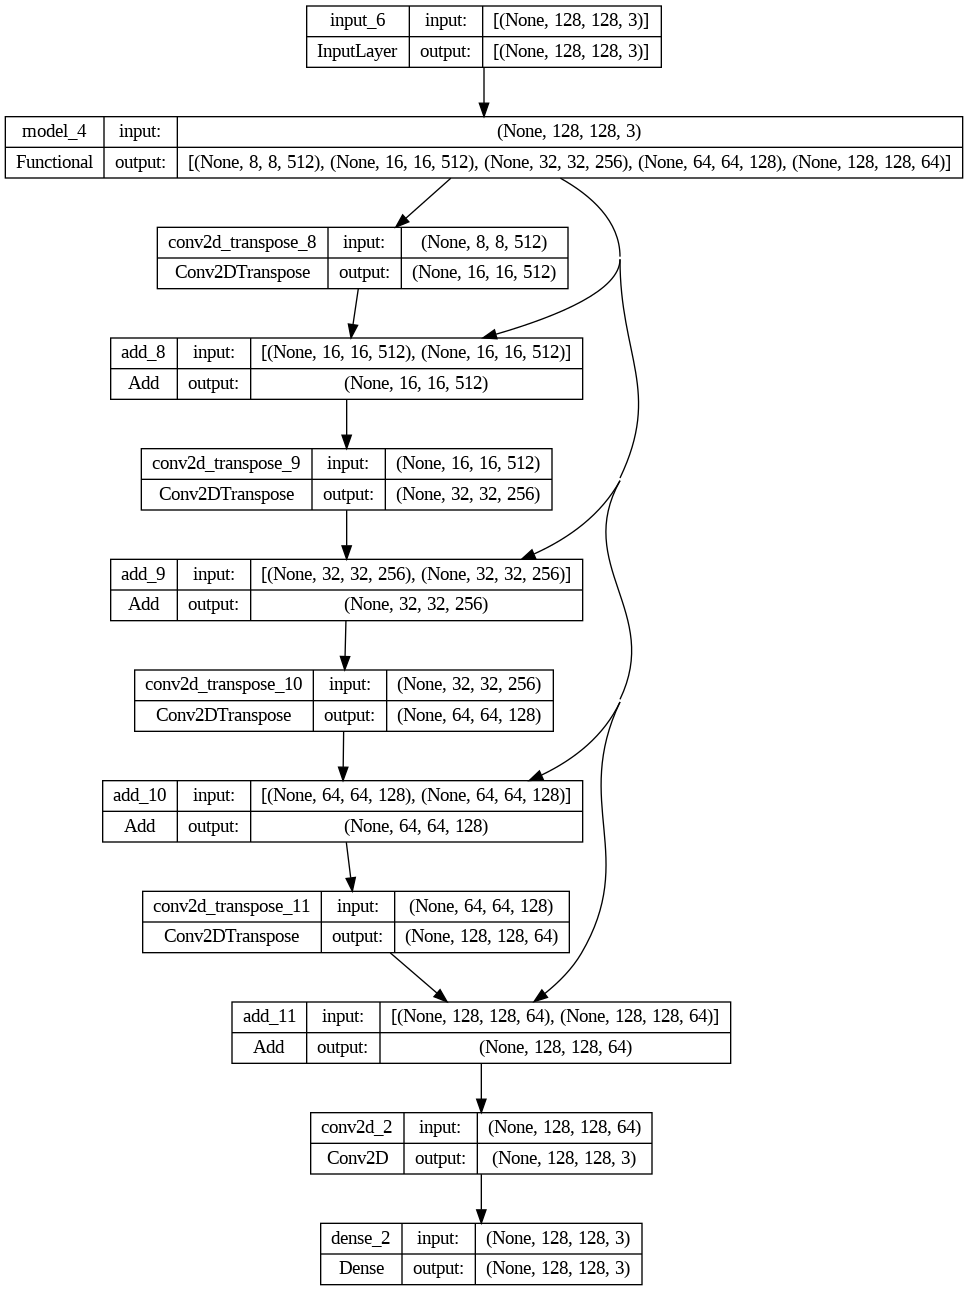

In [50]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [51]:
# 모델 요약
unet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           [(None, 8, 8, 512),  14714688    ['input_6[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [52]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/50
230/230 [==============================] - 21s 73ms/step - loss: 1.0295 - accuracy: 0.5875
Epoch 2/50
230/230 [==============================] - 19s 73ms/step - loss: 0.7288 - accuracy: 0.6999
Epoch 3/50
230/230 [==============================] - 19s 75ms/step - loss: 0.5893 - accuracy: 0.7847
Epoch 4/50
230/230 [==============================] - 20s 75ms/step - loss: 0.5384 - accuracy: 0.8155
Epoch 5/50
230/230 [==============================] - 21s 80ms/step - loss: 0.5089 - accuracy: 0.8290
Epoch 6/50
230/230 [==============================] - 20s 76ms/step - loss: 0.4887 - accuracy: 0.8369
Epoch 7/50
230/230 [==============================] - 20s 77ms/step - loss: 0.4742 - accuracy: 0.8433
Epoch 8/50
230/230 [==============================] - 20s 76ms/step - loss: 0.4603 - accuracy: 0.8498
Epoch 9/50
230/230 [==============================] - 20s 75ms/step - loss: 0.4490 - accuracy: 0.8529
Epoch 10/50
230/230 [==============================] - 19s 75ms/step - loss: 0.440

1/1 [==============================] - 0s 389ms/step


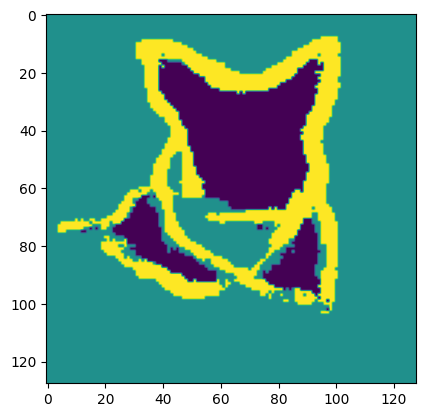

In [53]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

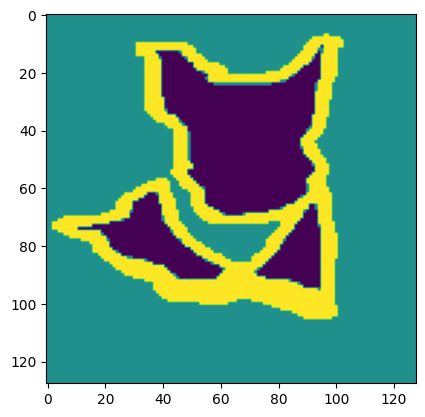

In [54]:

# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))